In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from datetime import datetime, date
from statsmodels.tsa.stattools import adfuller

# Time Series Forecasting

In [63]:
df = pd.read_csv('data/water-analytics.csv')
df.head(5)

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [64]:
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater',
                'Temperature', 'Drainage_Volume', 'River_Hydrometry']
target = 'Depth_to_Groundwater'
features = [feature for feature in df.columns if feature not in target]
df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')

In [65]:
df['River_Hydrometry'] = np.where(df['River_Hydrometry'] == 0, np.nan, df['River_Hydrometry'])
df['Drainage_Volume'] = np.where(df['Drainage_Volume'] == 0, np.nan, df['Drainage_Volume'])

In [26]:
features.remove('Date')

# Visualizations

First we have a general look at the missing data.

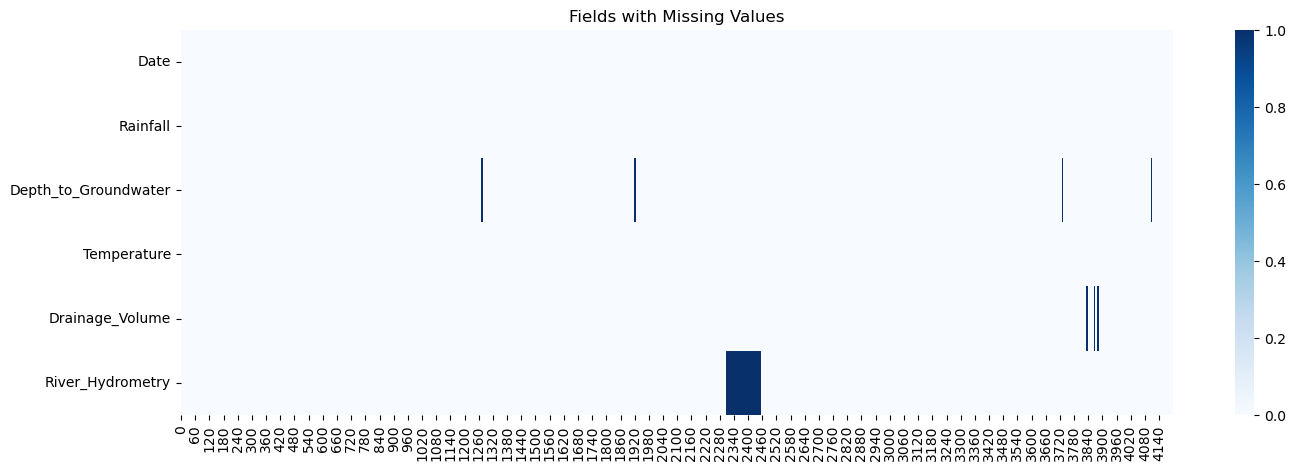

In [62]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values')
plt.show()

We interpolate the missing data.

In [66]:
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()

Now we take another look at the data.

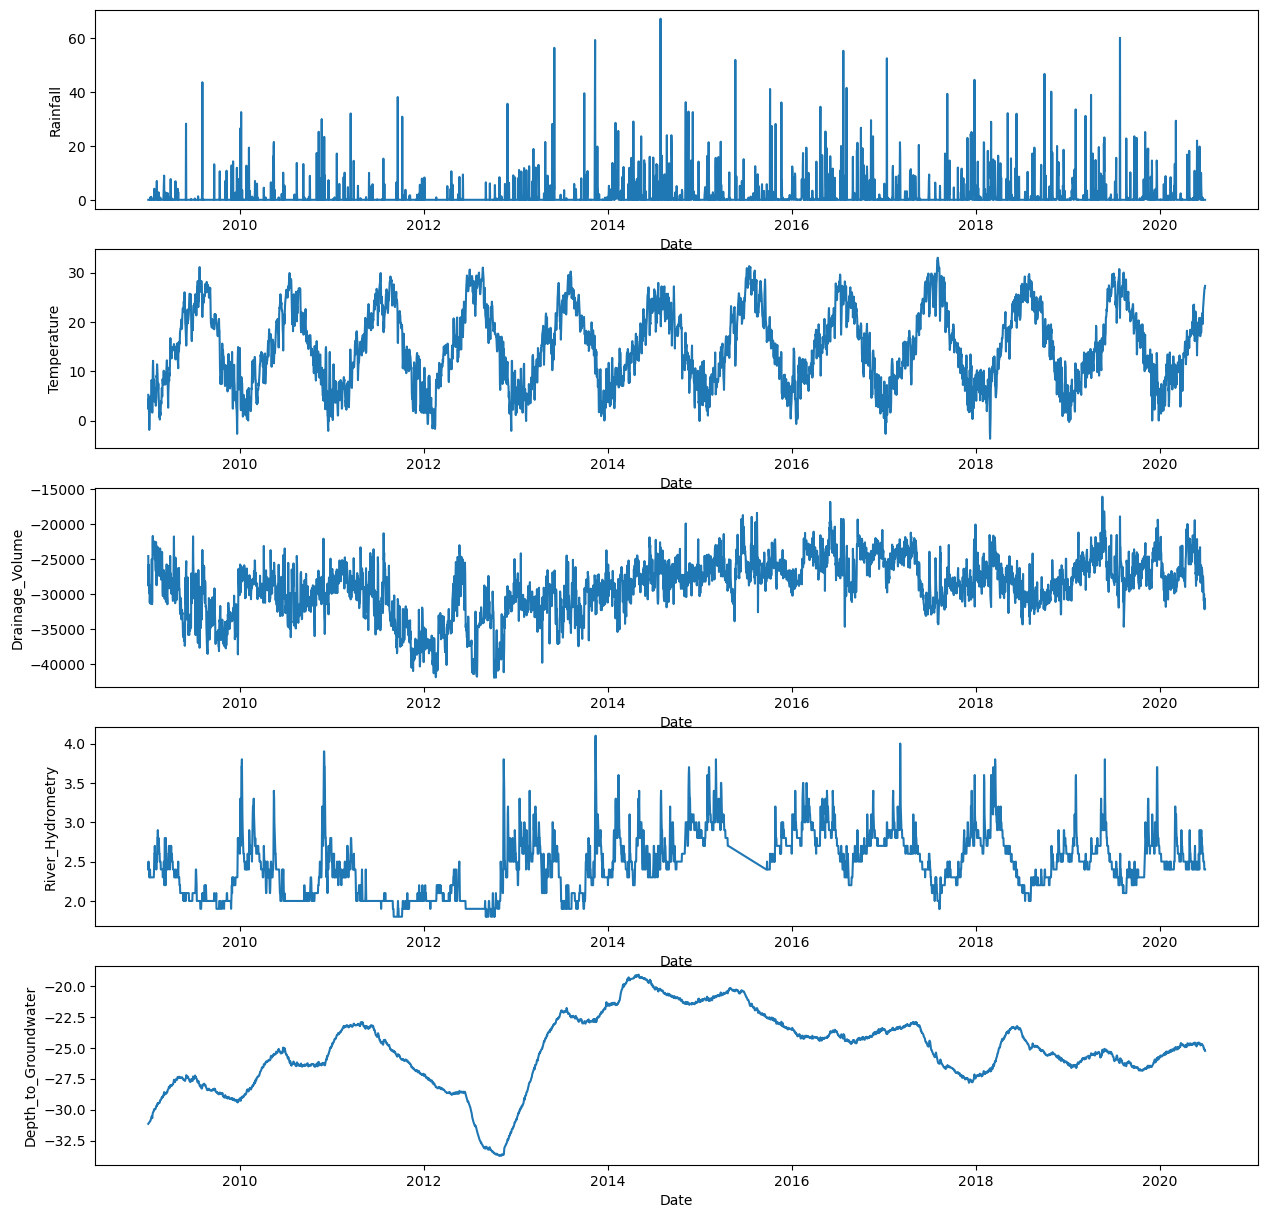

In [34]:
cols = features + ['Depth_to_Groundwater']

n = len(cols)
f, ax = plt.subplots(nrows=n, ncols=1, figsize=(15, 15))

for i in range(0, n):
    sns.lineplot(x=df['Date'], y=df[cols[i]], ax=ax[i])

plt.show()

We perform a rolling window analysis.

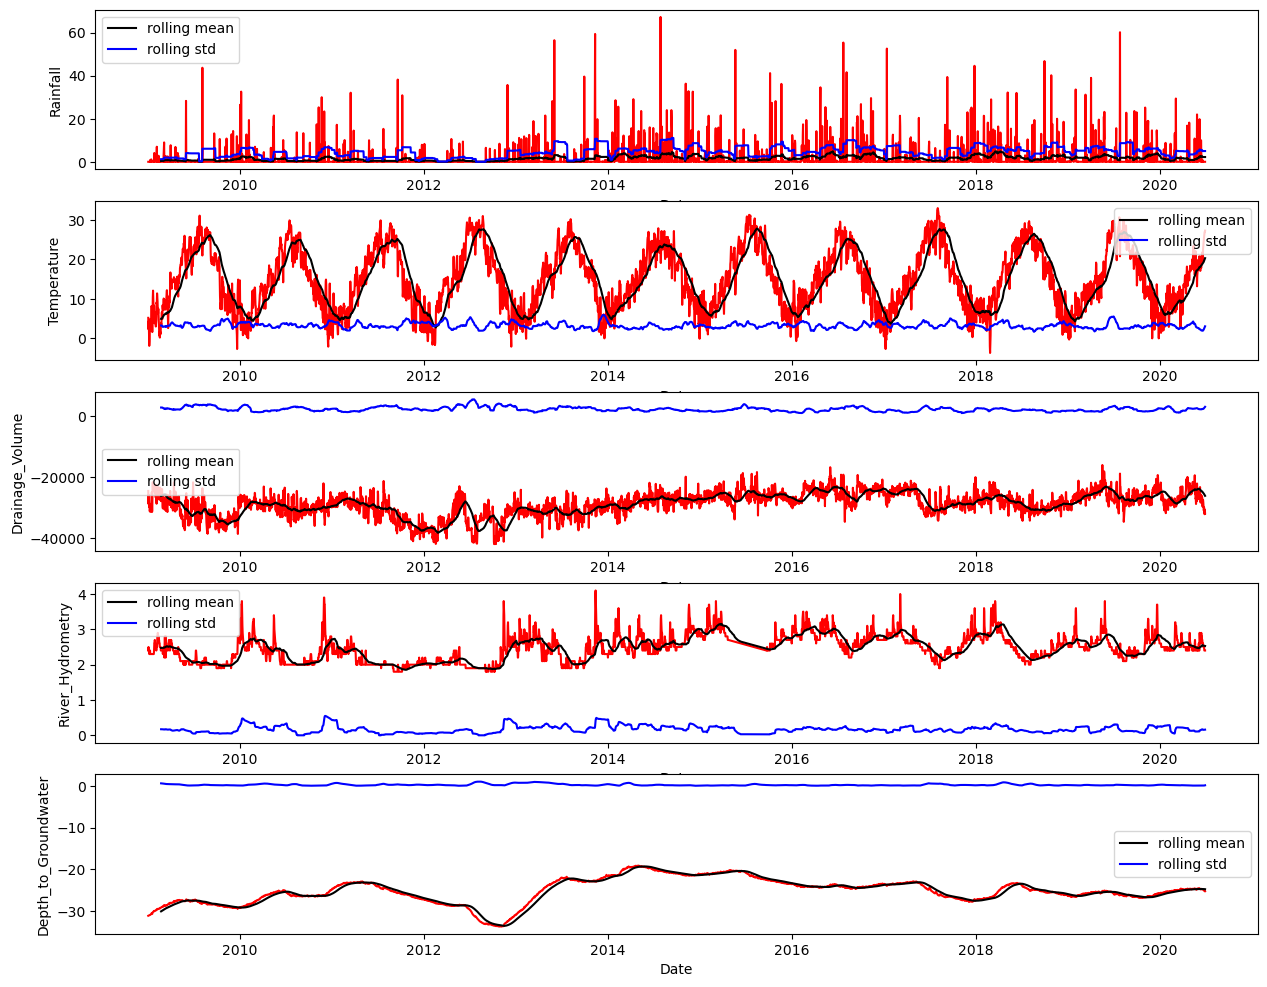

In [37]:
n = len(cols)
f, ax = plt.subplots(nrows=n, ncols=1, figsize=(15, 12))

for i in range(0, n):
    sns.lineplot(x=df['Date'], y=df[cols[i]], ax=ax[i], color='red')
    sns.lineplot(x=df['Date'], y=df[cols[i]].rolling(52).mean(), ax=ax[i], color='black', label='rolling mean')
    sns.lineplot(x=df['Date'], y=df[cols[i]].rolling(52).std(), ax=ax[i], color='blue', label='rolling std')

# Downsampling

We don't really need this many samples. We downsample it by an interval of 7 days.

In [71]:
cols = [feature for feature in df.columns if feature != 'Date'
                                            or feature != 'Rainfall']

df_re = df[cols].resample('7D', on='Date').mean().reset_index(drop=False)
df_re['Rainfall'] = df[['Date', 'Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)['Rainfall']

# Time Series Observations

In [72]:
results = pd.DataFrame(columns=['ADF Statistic', 'p-value', '5% Critical Value'])

cols.remove('Date')

for feat in cols:
    result = adfuller(df_re[feat].values)
    adf_stat = result[0]
    p = result[1]
    crit_val_5 = result[4]['5%']
    results.loc[feat] = [round(adf_stat,3), 
                        round(p,3), 
                        round(crit_val_5,3)]

results

,ADF Statistic,p-value,5% Critical Value
Rainfall,-3.374,0.012,-2.867
Depth_to_Groundwater,-2.880,0.048,-2.866
Temperature,-12.034,0.000,-2.867
Drainage_Volume,-3.010,0.034,-2.866
River_Hydrometry,-4.824,0.000,-2.866


They are not stationary. Therefore we differentiate the time series.

In [74]:
results = pd.DataFrame(columns=['ADF Statistic', 'p-value', '5% Critical Value'])

for feat in cols:
    result = adfuller(np.diff(df_re[feat].values))
    adf_stat = result[0]
    p = result[1]
    crit_val_5 = result[4]['5%']
    results.loc[feat] = [round(adf_stat,3), 
                        round(p,3), 
                        round(crit_val_5,3)]

results

,ADF Statistic,p-value,5% Critical Value
Rainfall,-12.415,0.0,-2.867
Depth_to_Groundwater,-5.170,0.0,-2.866
Temperature,-8.278,0.0,-2.867
Drainage_Volume,-11.333,0.0,-2.866
River_Hydrometry,-11.746,0.0,-2.866


It didn't improve anything so it is better to just use the original series.

# Prediction with ARIMA models

To determine the parameters, we use ACF and PACF plots.

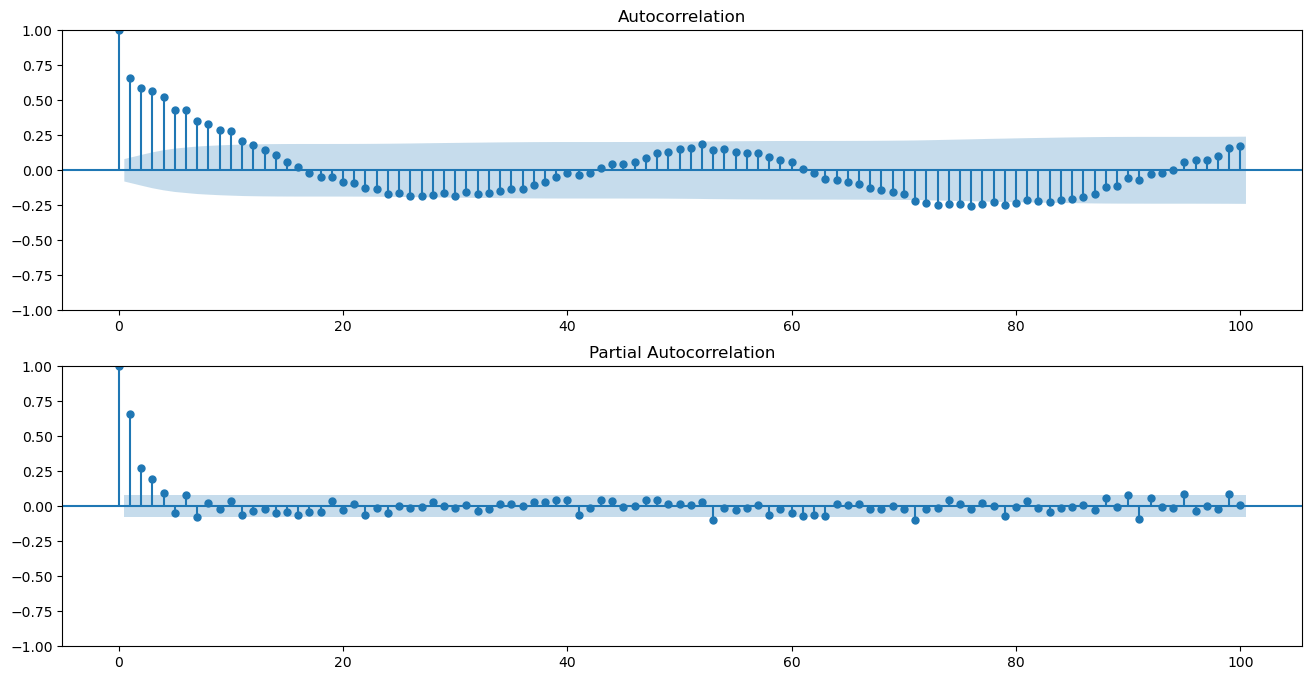

In [76]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(np.diff(df_re['Depth_to_Groundwater']), lags=100, ax=ax[0])
plot_pacf(np.diff(df_re['Depth_to_Groundwater']), lags=100, ax=ax[1])

plt.show()

The coefficients should be (4, 11)

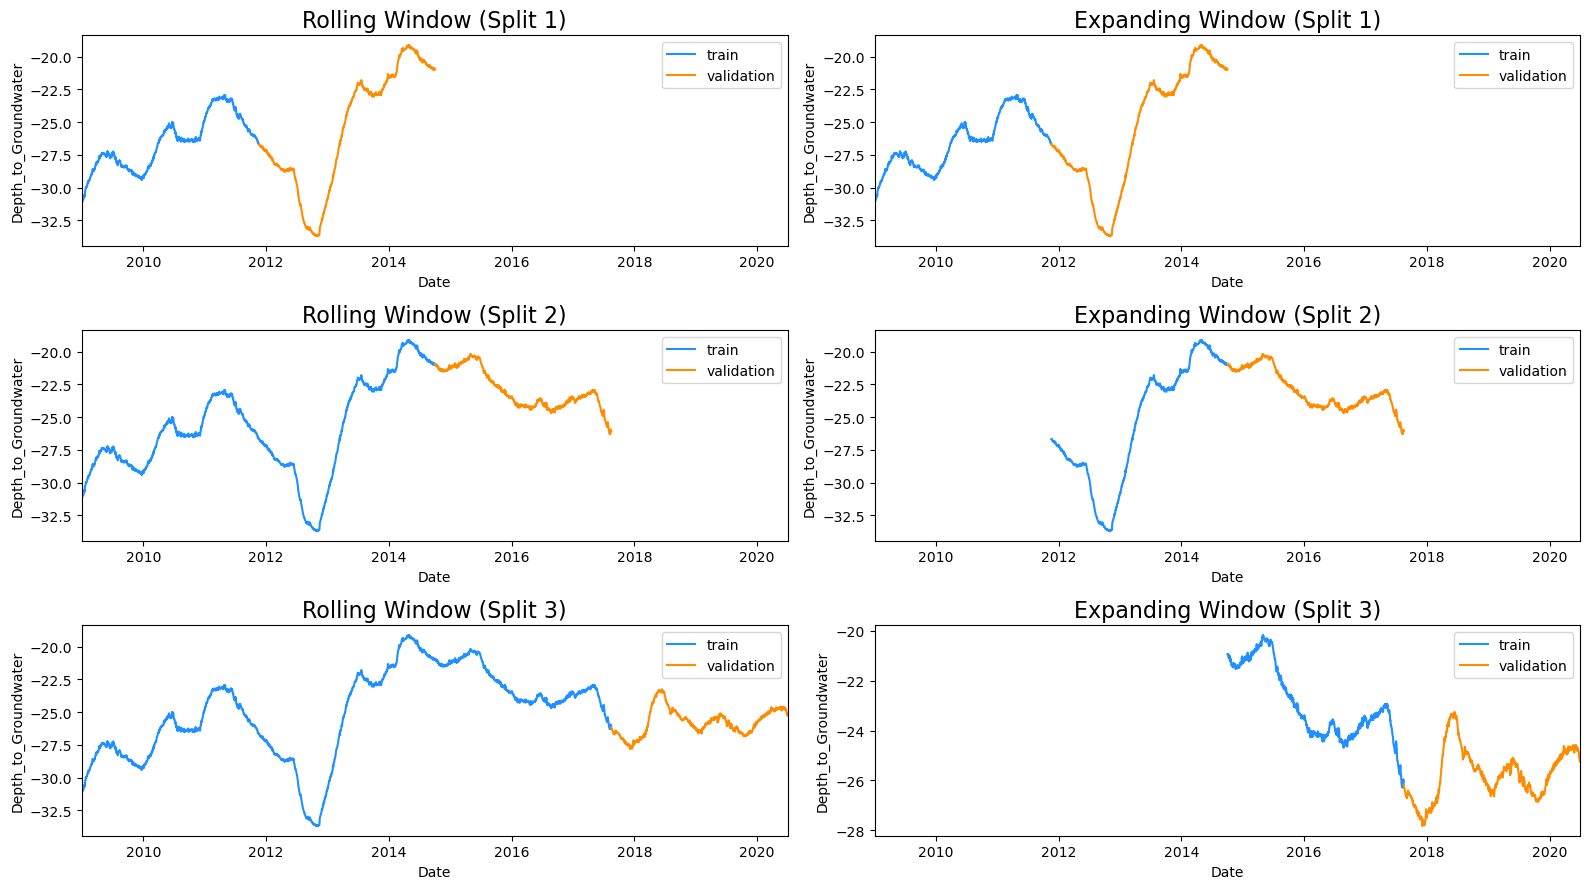

In [80]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df.Date
y = df.Depth_to_Groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train))],
                y= y_train[len(X_train) - len(X_valid):(len(X_train))],
                ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Expanding Window (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([X[0], X[len(X)-1]])
    ax[i, 1].set_xlim([X[0], X[len(X)-1]])

plt.tight_layout()
plt.show()

In [85]:
df = df_re
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter

In [86]:
df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

target = 'Depth_to_Groundwater'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 46

X = df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

In [102]:
def plot_approach_evaluation(y_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.Date, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.Date, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2) #navajowhite
    sns.lineplot(x=X_test.Date, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2018, 6, 30), date(2020, 6, 30)])
    ax[0].set_ylim([-27, -23])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

    sns.lineplot(x=range(0,44), y=score_mae,  color='gold', label='MAE', ax=ax[1]),
    sns.lineplot(x=range(0,44), y=score_rsme, color='red', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 4])
    plt.show()

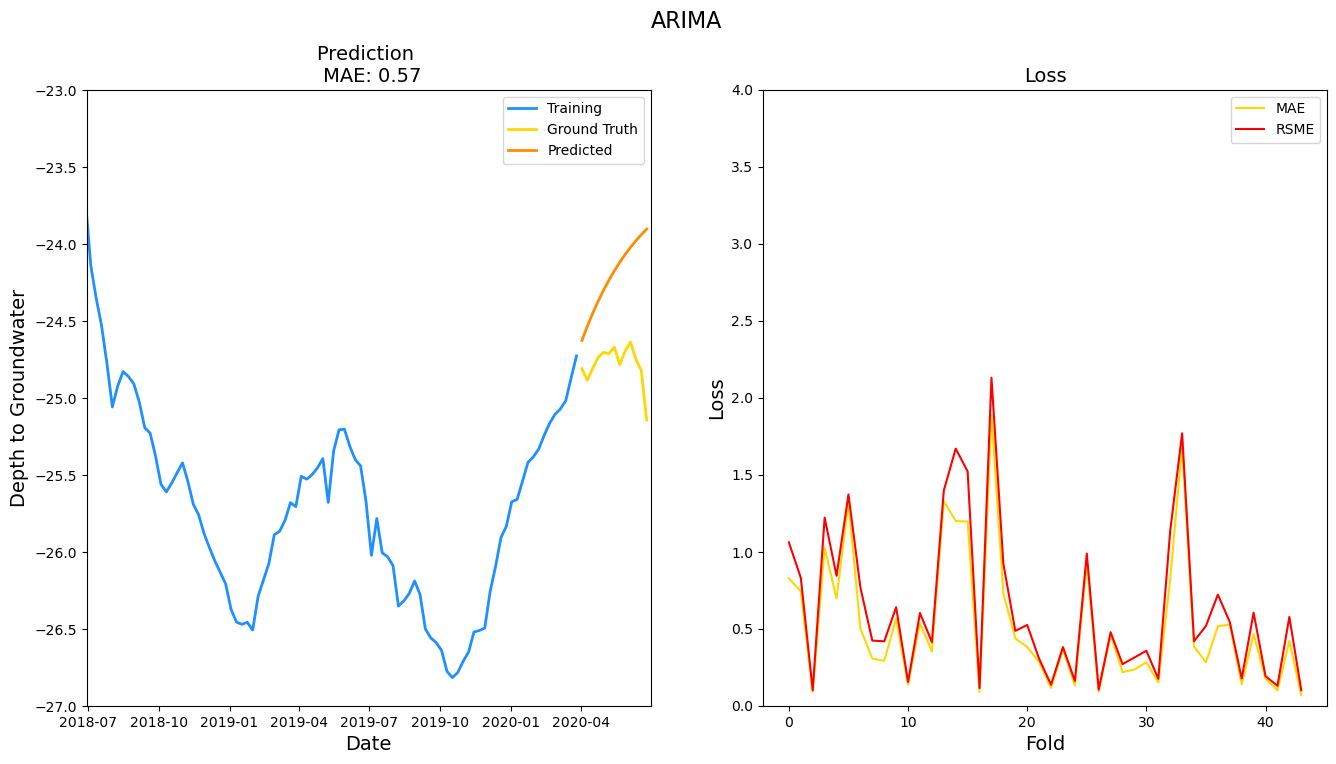

In [109]:
from statsmodels.tsa.arima.model import ARIMA

score_mae = []
score_rsme = []

for valid_quarter_id in range(2, N_SPLITS):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()

    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')